In [178]:
from pathlib import Path

from math import sqrt

import numpy as np
import pandas as pd

from numba import njit

from matplotlib import pyplot as plt

### Load reference data

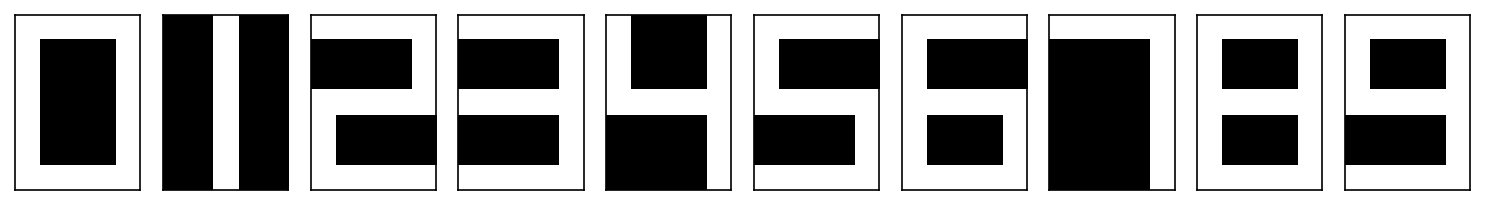

In [179]:
img_shape = (7, 5)
img_size = 35

data_path = Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [180]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [181]:
features = []
labels = []

for i, reference_sample in enumerate(data_mtrx):
    features.append(reference_sample)
    labels.append(one_hot_encoding(10, i))

    for j in range(9):
        noised_sample = reference_sample + np.random.uniform(0.0, 0.25, img_size)
        
        features.append(noised_sample)
        labels.append(one_hot_encoding(10, i))

features = np.array(features)
labels = np.array(labels)

### Split dataset to test and train

In [182]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = np.array(features[idx_test])
y_test = np.array(labels[idx_test])

x_train = np.array(features[idx_train])
y_train = np.array(labels[idx_train])

### Define functions

In [183]:
def one_hot(n: int, i: int) -> np.ndarray:
    q = np.zeros(n)
    q[i] = 1.0
    return q


@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return (a @ b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mcosim(m: np.ndarray, x: np.ndarray) -> float:
    y = np.zeros(m.shape[0])
    x_norm = norm(x)
    
    for i in range(m.shape[0]):
        y[i] = (m[i] @ x) / (norm(m[i]) * x_norm)
        
    return y


@njit(fastmath=True)
def project(x: np.ndarray, m: np.ndarray) -> np.ndarray:
    return (m @ x) / np.sum(m * m, axis=1)


@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [201]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray, W: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)

    for i in range(x_batch.shape[0]):
        h = W.T @ y_batch[i]
        # dh = dReLU(h)
        # x = V.T @ ReLU(h)
        x = V.T @ h

        dLdx = 2 * (x - x_batch[i])
        # dLdh = V @ dLdx * dh
        dLdh = V @ dLdx

        dLdV = np.outer(h, dLdx)
        dLdw = np.outer(y_batch[i], dLdh)

        dV += dLdV
        dW += dLdw

    return (dV, dW)


class Perceptron:
    def __init__(self, nIn: int, nH: int, nOut: int) -> None:
        self.nIn = nIn
        self.nH = nH
        self.nOut = nOut

        self.V: np.ndarray = np.random.uniform(-1, 1, (nH, nIn))
        self.W: np.ndarray = np.random.uniform(-1, 1, (nOut, nH))

    def predict(self, y: np.ndarray) -> np.ndarray:
        # return self.V.T @ ReLU(self.W.T @ y)
        return self.V.T @ (self.W.T @ y)

    def loss(self, y_batch: np.ndarray, x_batch: np.ndarray) -> float:
        x_pred_batch = np.array([self.predict(y) for y in y_batch])
        d = np.sum(np.square(x_pred_batch - x_batch), axis=1)
        return np.mean(d)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dV, dW = grads(x_train[batch_idxs], y_train[batch_idxs], self.V, self.W)

                self.V -= lr * dV
                self.W -= lr * dW

### Create and train model

In [223]:
nIn = 35
nH = 16
nOut = 10

learning_rate = 1e-2
batch_size = 8
max_epoch = 256

model = Perceptron(nIn, nH, nOut)

print('untrained loss: ', model.loss(y_test, x_test).round(4))

model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

print('trained loss: ', model.loss(y_test, x_test).round(4))

untrained loss:  78.738
trained loss:  0.3943


In [224]:
W = model.W
V = model.V

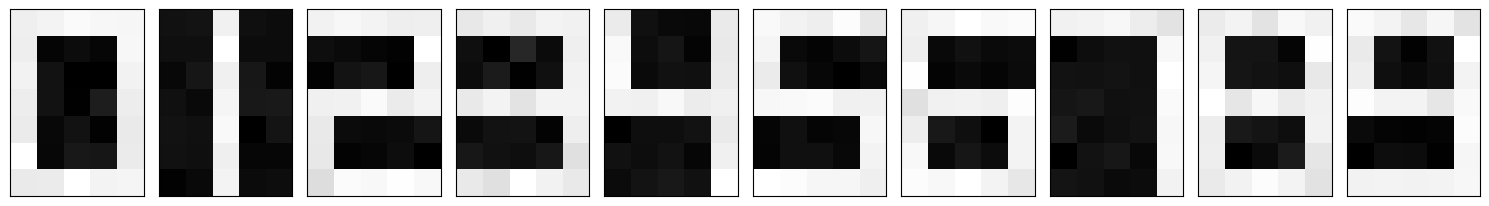

In [225]:
fig, axes = plt.subplots(nrows=1, ncols=10)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.set_dpi(100)

for i, ax in enumerate(axes.ravel()):
    x = V.T @ W[i]
    # x = V.T @ ReLU(W[i])
    img = ax.imshow(x.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# print(np.round(np.apply_along_axis(sigmoid, 0, W).T, 3))
# print(np.round(W.T, 3))

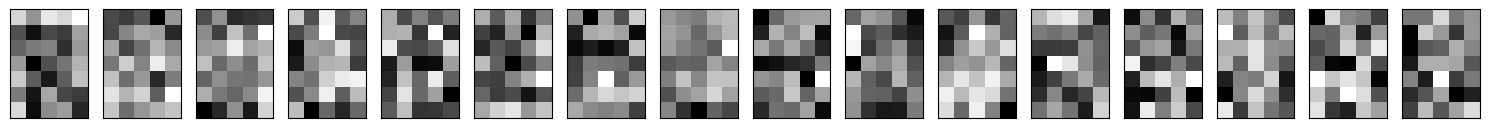

In [226]:
fig, axes = plt.subplots(nrows=1, ncols=nH)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.set_dpi(100)

for i, ax in enumerate(axes.ravel()):
    img = ax.imshow(V[i].reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

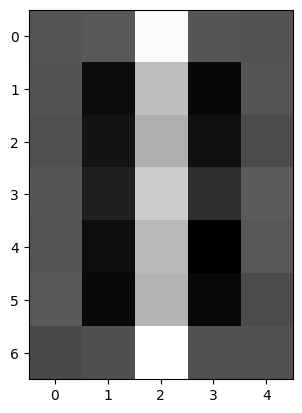

In [227]:
y = np.array([0.2, 0.7, 0, 0, 0, 0, 0, 0.0, 0.1, 0.0])
x = model.predict(y)

plt.imshow(x.reshape(img_shape), cmap='binary_r')
plt.show()